In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
square = [(0.5,0.5,0.0,0.0,0.0,0.0),
         (0.5,0.5,0.0,0.0,0.5,0.0),
         (0.5,0.5,0.0,0.0,0.0,0.5),
         (0.5,0.5,0.0,0.0,0.5,0.5)]

intervals=[-0.5,-0.01,0.0,0.01,0.5]

bins4 = [0.25*i for i in range(0,5)]
bins8 = [0.125*i for i in range(0,9)]

def toaffine(param):
    r,s,theta,phi,e,f = param
    return np.array([[r*np.cos(theta), -s*np.sin(phi)],[r*np.sin(theta), s*np.cos(phi)]]), np.array([e,f])

In [4]:
def get_data(ticker,start='2018-01-01',end='2021-10-19',n_days=705):
    df = yf.download(ticker, 
                          start=start, 
                          end=end, 
                          progress=False)
    return df

In [49]:
def data2sequence(df,col="Adj Close", pct_change=False,equal_width=False,std_norm=False,shuffle=False):
    if pct_change:
        df["Return"] = df[col].pct_change()
    else:
        df["Return"] = df[col]-df[col].shift(1)

    df["Return_std"] = df["Return"]/(df["Return"].std())
    if std_norm:
        variable = "Return_std"
    else:
        variable = "Return"
    if equal_width:
        df["T"] = pd.cut(df[variable], intervals, labels=[0, 1, 2, 3])
    else:
        df["T"] = pd.qcut(df[variable], [0, .25, .5, .75, 1.], labels=[0, 1, 2, 3])
    df.dropna(inplace=True)
    sequence = np.array(df["T"].values)
    if shuffle:
        np.random.shuffle(sequence)   

    return df[variable],sequence

In [50]:
def rnd2sequence(n_days):
    df = pd.DataFrame({"Return":
                           np.random.normal(0.0,0.015,size=n_days)})
    df["T"] = pd.cut(df["Return"], intervals, labels=[0, 1, 2, 3])

    df.dropna(inplace=True)
    
    return df["Return"],np.array(df["T"].values)

In [51]:
def logistic2sequence(n_days,x0=0.2,r=4):
    x = x0
    hist = [x]
    for _ in range(n_days):
        x = r*x*(1-x)
        hist.append(x)
    df = pd.DataFrame({"Return":hist})
    
    df["T"] = pd.cut(df["Return"], [0.,0.25,0.5,0.75,1.], labels=[0, 1, 2, 3])
    #df["T"] = pd.qcut(df["Return"], [0, .25, .5, .75, 1.], labels=[0, 1, 2, 3])
    df.dropna(inplace=True)
    return df["Return"],np.array(df["T"].values )

In [52]:
def get_ifsbin(sequence,bins):
    x = np.float64([0.5,0.5])
    lp = [x]
    for c in sequence:
        m,b = toaffine(square[int(c)])
        x = np.matmul(m,x) + b
        lp.append(x)

    cx,cy = np.transpose(lp)
    h,xedges,yedges=np.histogram2d(cx,cy,bins=bins)
    return h

In [53]:
def create_plot(series,sequence,title="Plot",hlines=True,quiver=True,intervals=intervals):
    x = np.float64([0.5,0.5])
    lp = [x]
    for c in sequence:
        m,b = toaffine(square[int(c)])
        x = np.matmul(m,x) + b
        lp.append(x)

    cx,cy = np.transpose(lp)
    nred=1
    if quiver:
        nred = 5
    c = np.array(["blue"]*len(cx))
    c[-nred:]="red"
    s=np.array([2.0]*len(cx))
    s[-nred:]=30.0
    fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(20,8))
    axs[1].scatter(cx,cy,s=s,c=c)
    if quiver:
        axs[1].quiver(cx[-nred:-1],cy[-nred:-1],
                  cx[-nred+1:]-cx[-nred:-1],cy[-nred+1:]-cy[-nred:-1],
                  scale_units='xy', angles='xy',scale=1, width=0.001,
                  headwidth=50, headlength=50, headaxislength=50,linewidth=1000,color="r")
    #last_state = [s+1 for s in sequ[-nred:]]
    axs[1].set_aspect('equal', 'box')
    #ax.set_title(f"{ticker} - N_points: {len(cx)} \n {last_state}")
    axs[1].set_xticks([0.0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1.0])
    axs[1].set_yticks([0.0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1.0])
    axs[1].grid("both")
    axs[0].plot(series,alpha=0.7)
    axs[0].set_xlabel("date", fontsize=18)
    axs[0].set_ylabel(f"{title}", fontsize=18)
    if hlines:
        xlim = axs[0].get_xlim()
        for y in intervals[1:-1]:
            axs[0].hlines(y,xlim[0],xlim[1],colors='r', linestyles='dashdot')
    fig.suptitle(title,fontsize=22)
    plt.show()
    plt.close()

In [54]:
def ifs_correlation(ifsbin1,ifsbin2):
    N = np.sum(ifsbin1)
    if N!=np.sum(ifsbin2):
        print("ERROR: different number of entries")
        return None
    else:
        return 1/N*(N-0.5*np.sum(np.abs(ifsbin1-ifsbin2)))

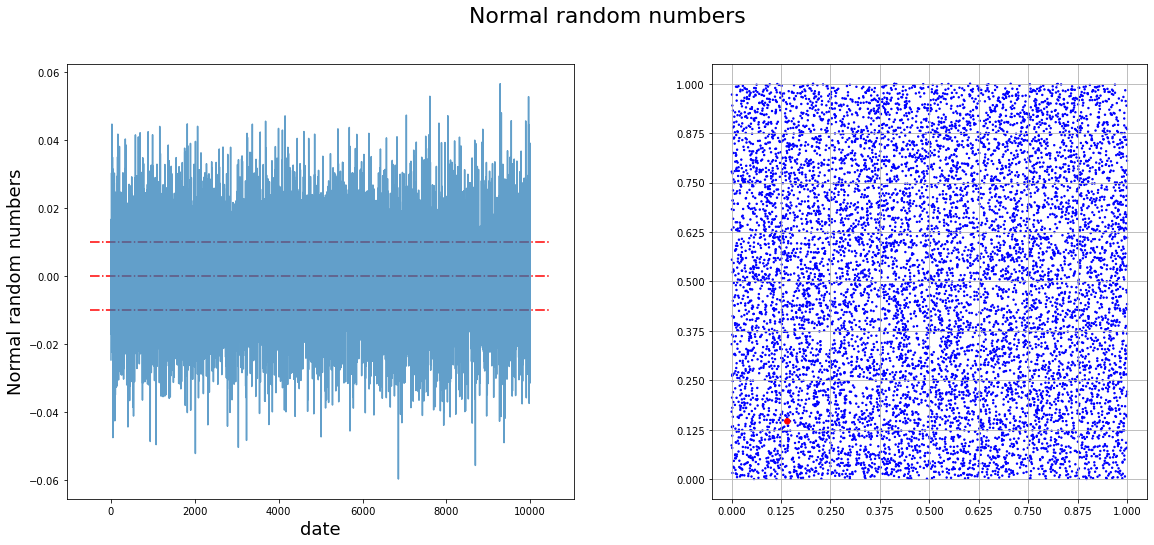

In [55]:
series,sequence = rnd2sequence(10000)
create_plot(series,sequence,"Normal random numbers",quiver=False)

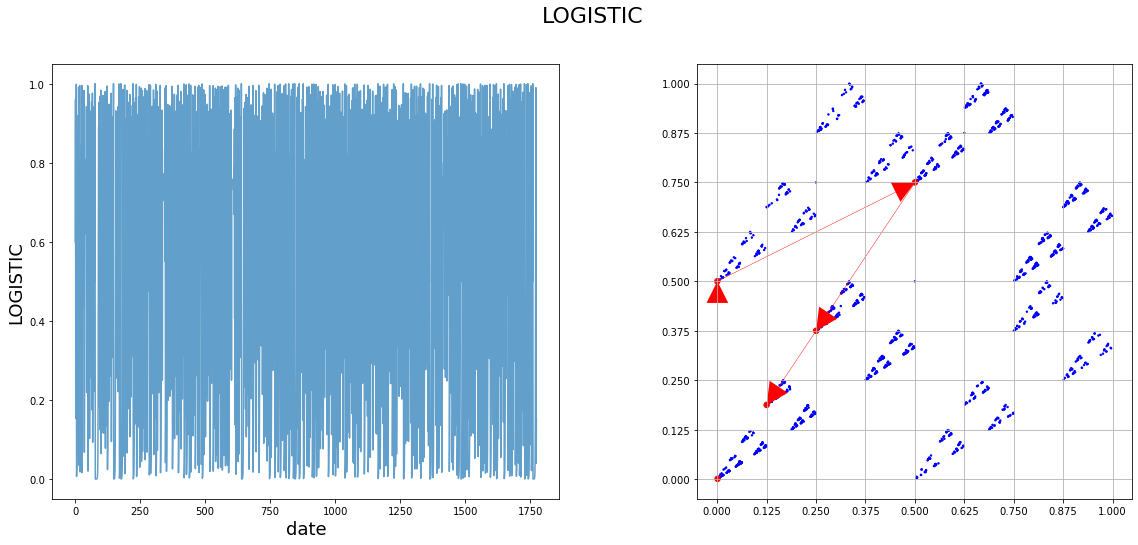

In [56]:
series,sequence = logistic2sequence(1774,x0=0.6)
create_plot(series,sequence,hlines=False,title="LOGISTIC")

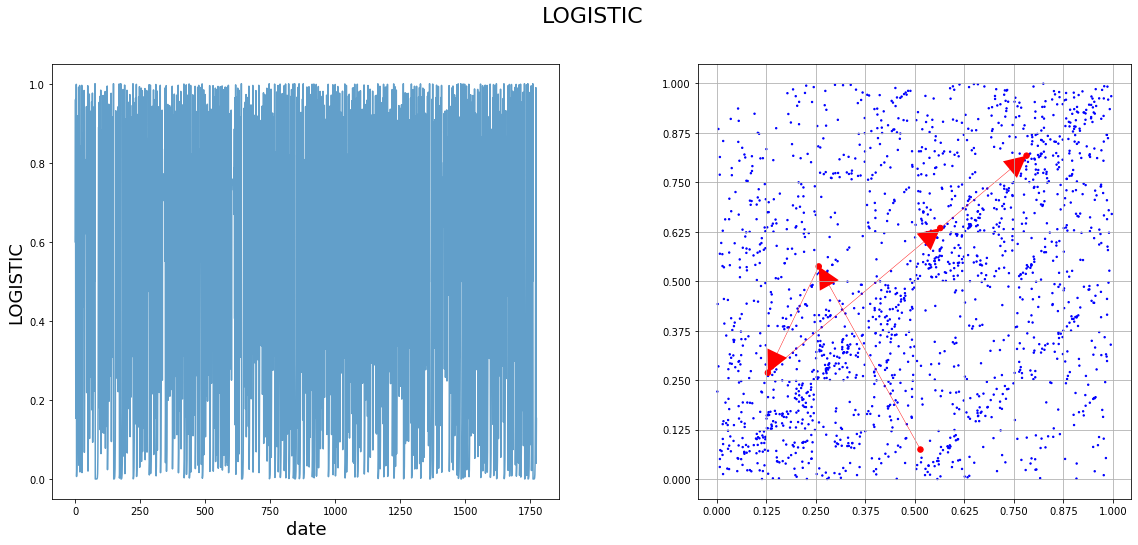

In [57]:
series,sequence = logistic2sequence(1774,x0=0.6)
np.random.shuffle(sequence)
create_plot(series,sequence,hlines=False,title="LOGISTIC")

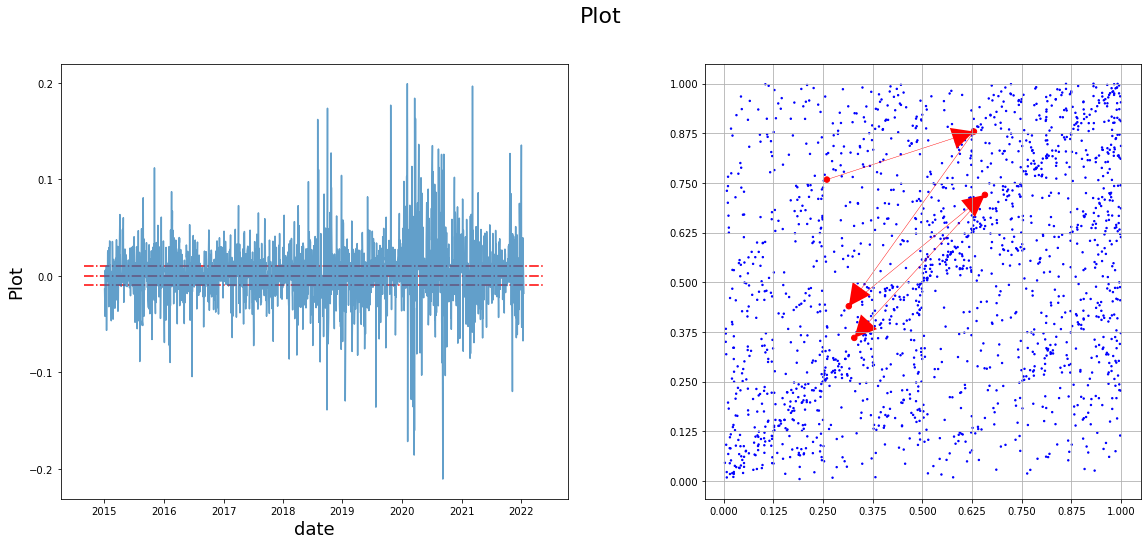

In [58]:
series,sequence = data2sequence(get_data("TSLA",start='2015-01-01',end='2022-01-19',n_days=1700),
                                    pct_change=True,equal_width=True,std_norm=False)
create_plot(series,sequence)

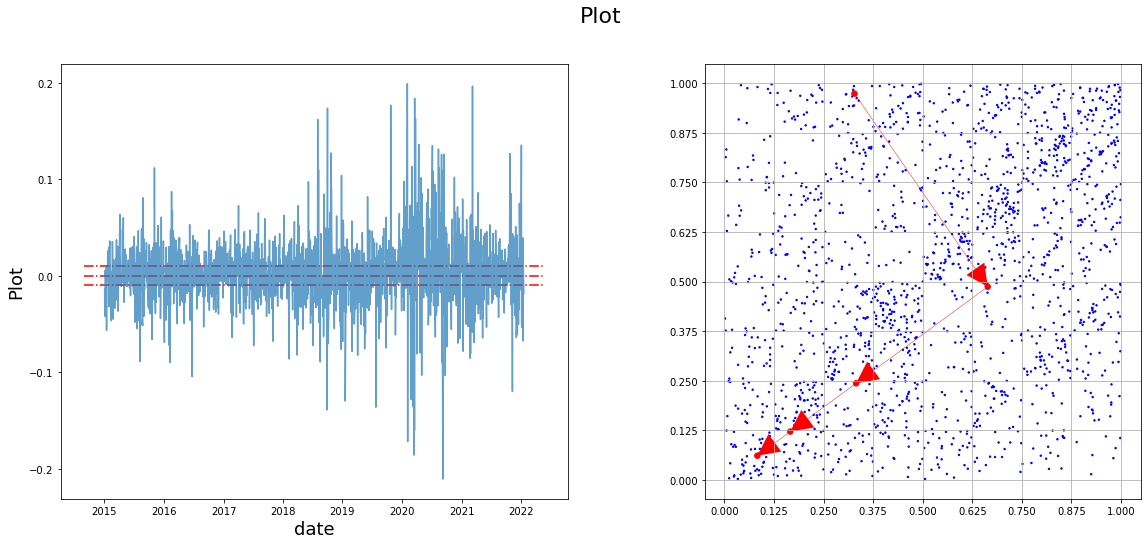

In [59]:
series,sequence = data2sequence(get_data("TSLA",start='2015-01-01',end='2022-01-19',n_days=1700),
                                    pct_change=True,equal_width=True,std_norm=False,shuffle=True)
create_plot(series,sequence)

In [60]:
series

Date
2015-01-02   -0.013938
2015-01-05   -0.042041
2015-01-06    0.005664
2015-01-07   -0.001562
2015-01-08   -0.001564
                ...   
2022-01-11    0.005935
2022-01-12    0.039290
2022-01-13   -0.067491
2022-01-14    0.017498
2022-01-18   -0.018197
Name: Return, Length: 1774, dtype: float64

In [61]:
sequence

array([3, 3, 3, ..., 0, 0, 0])

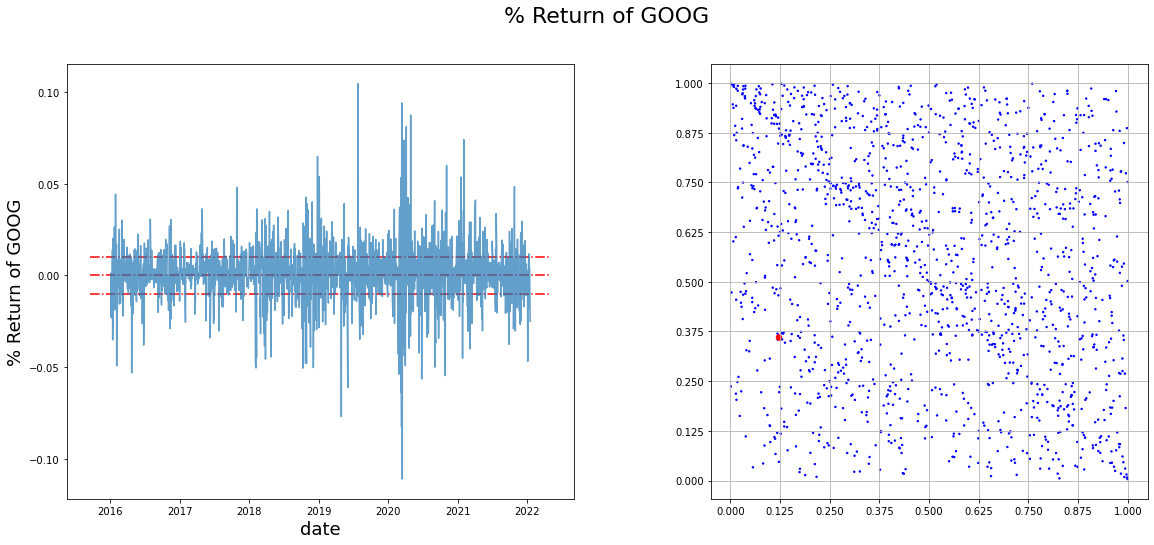

In [62]:
series,sequence = data2sequence(get_data("GOOG",start='2016-01-01',end='2022-01-19',n_days=1700),
                                    pct_change=True,equal_width=True,std_norm=False)
create_plot(series,sequence,"% Return of GOOG",quiver=False)

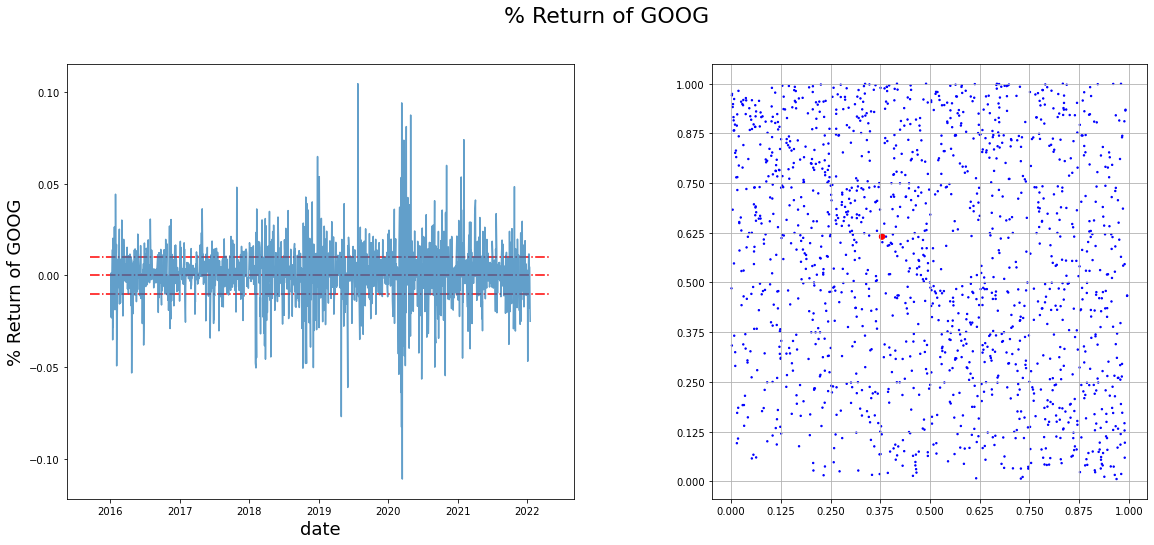

In [63]:
series,sequence = data2sequence(get_data("GOOG",start='2016-01-01',end='2022-01-19',n_days=1700),
                                    pct_change=True,equal_width=True,std_norm=False,shuffle=True)
create_plot(series,sequence,"% Return of GOOG",quiver=False)

In [23]:
ticker_list=[
"AAPL",
"MSFT",
"GOOG",
"GOOGL",
"AMZN",
"FB",
"TSLA",
"TSM",
"NVDA",
"JPM",
"V",
"BABA",
"IDX",
"JNJ",
"UNH",
"BAC"]
ticker_ifs = {}

### USARE pct_change=True,equal_width=True,std_norm=False sulle azioni

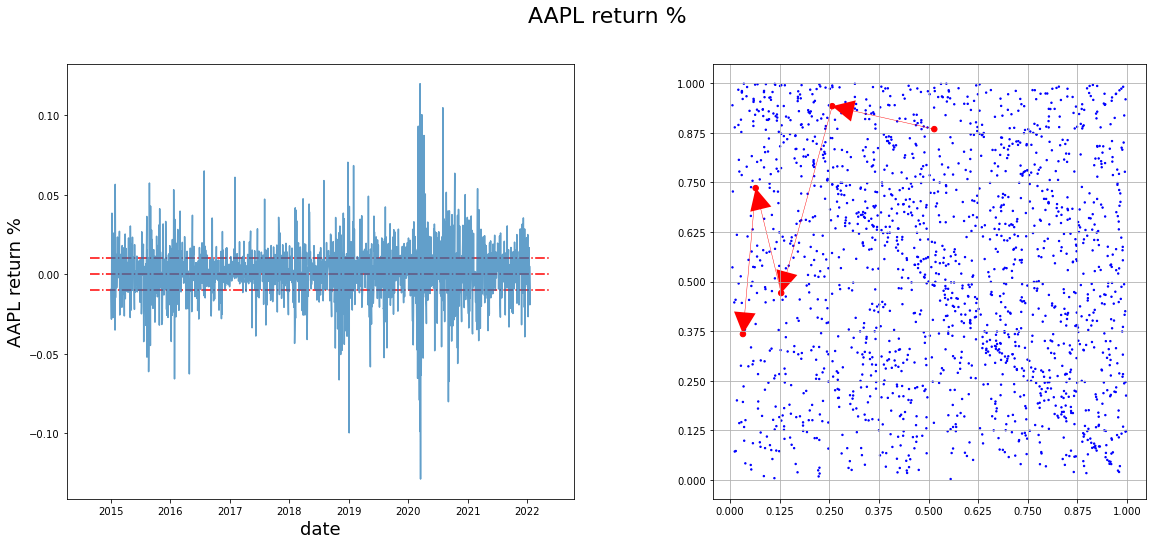

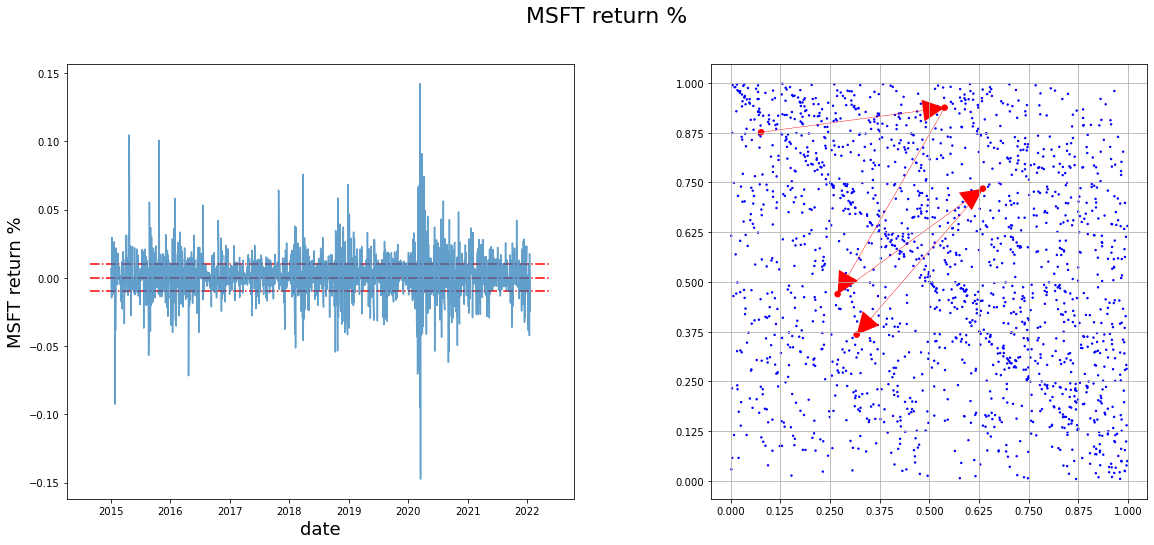

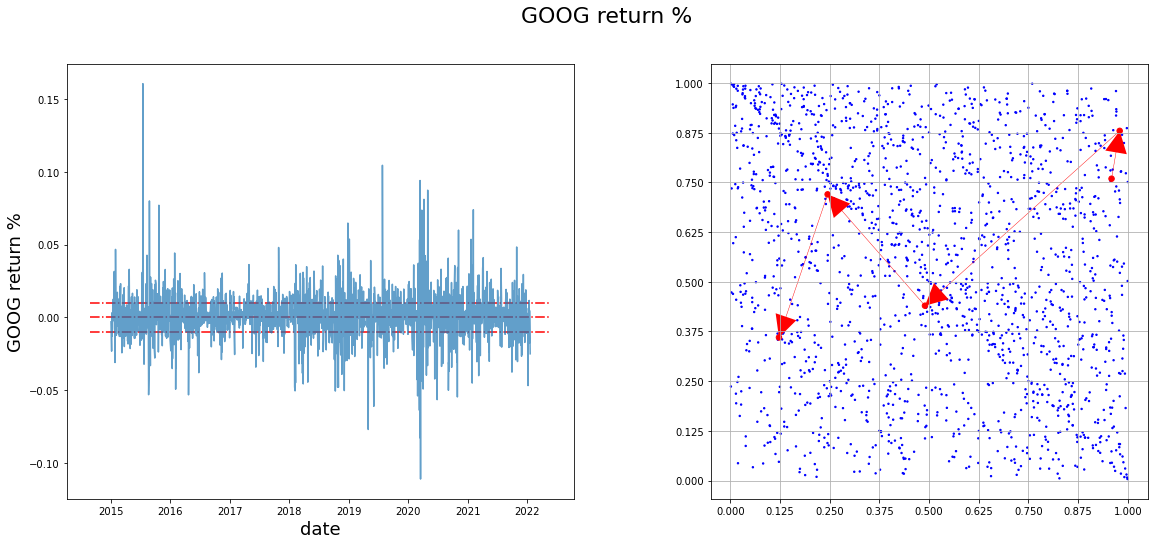

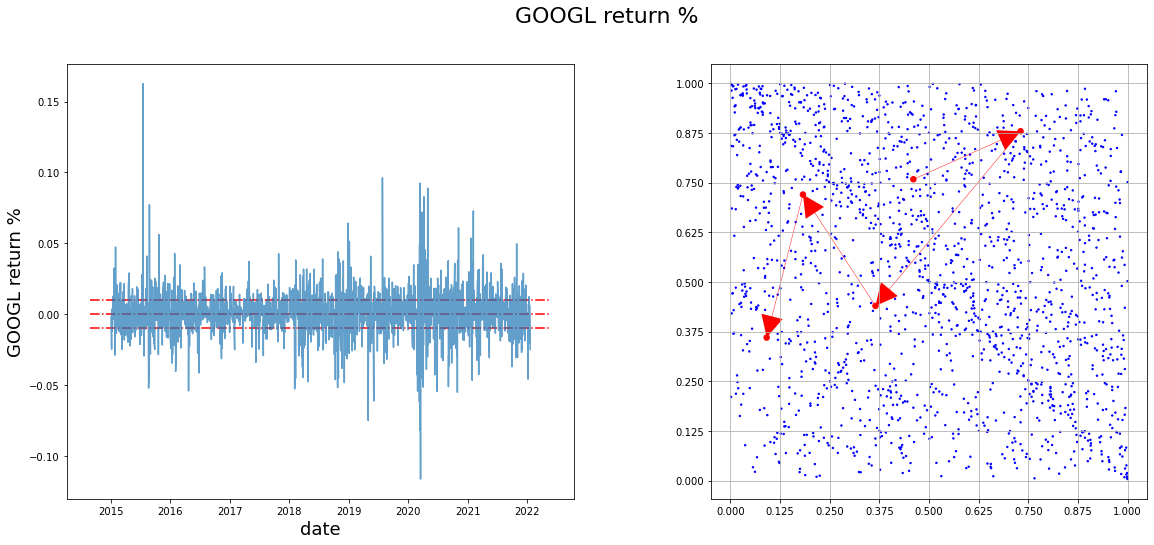

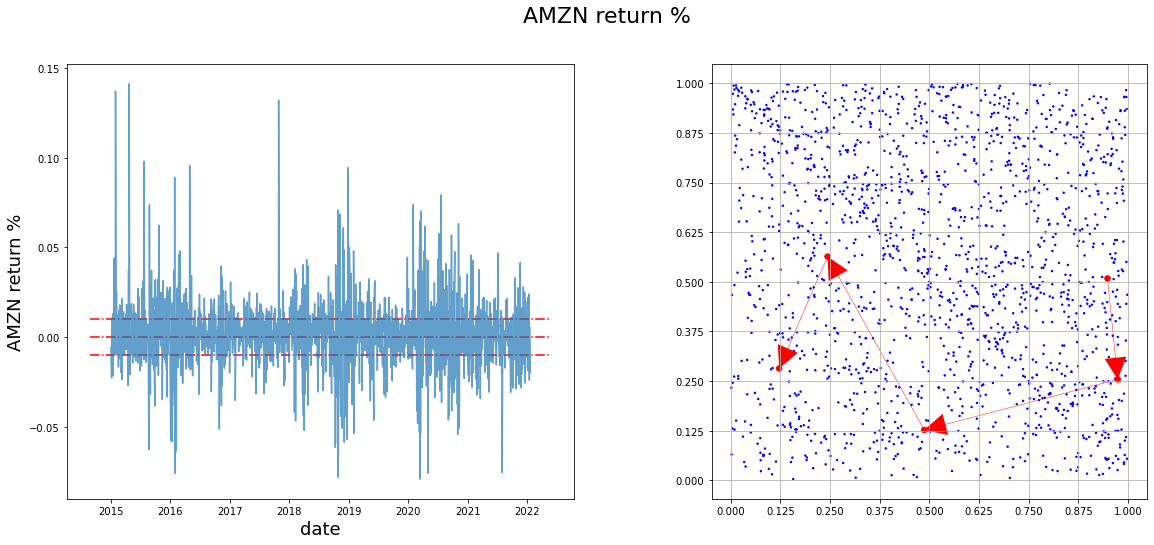

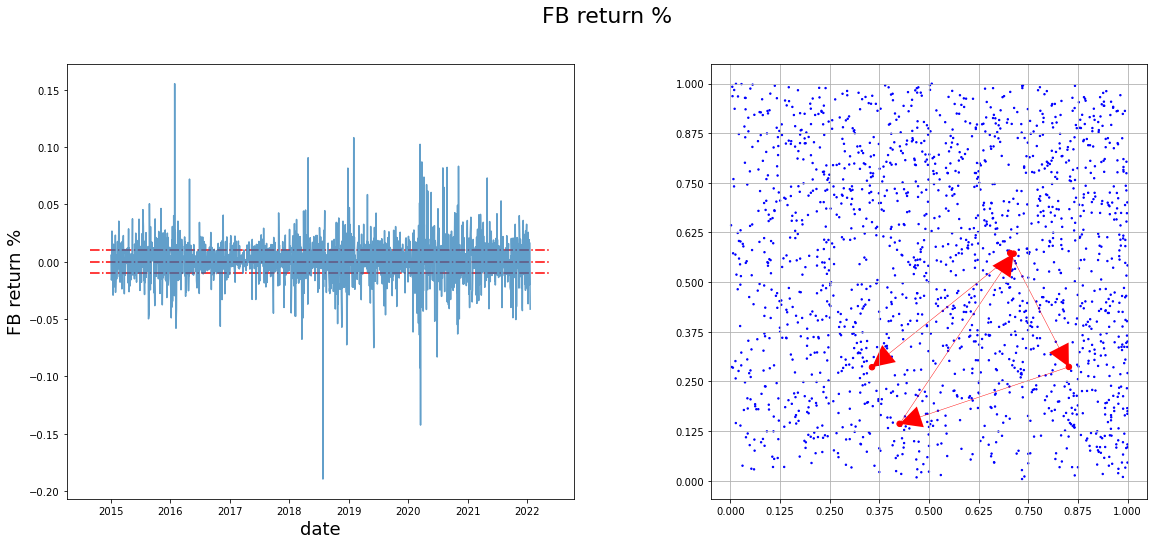

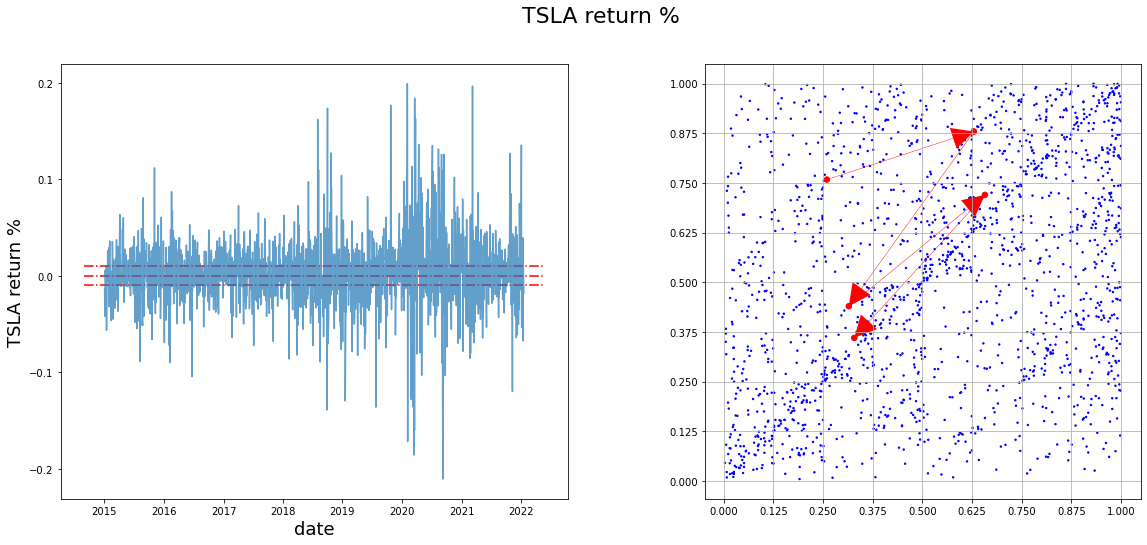

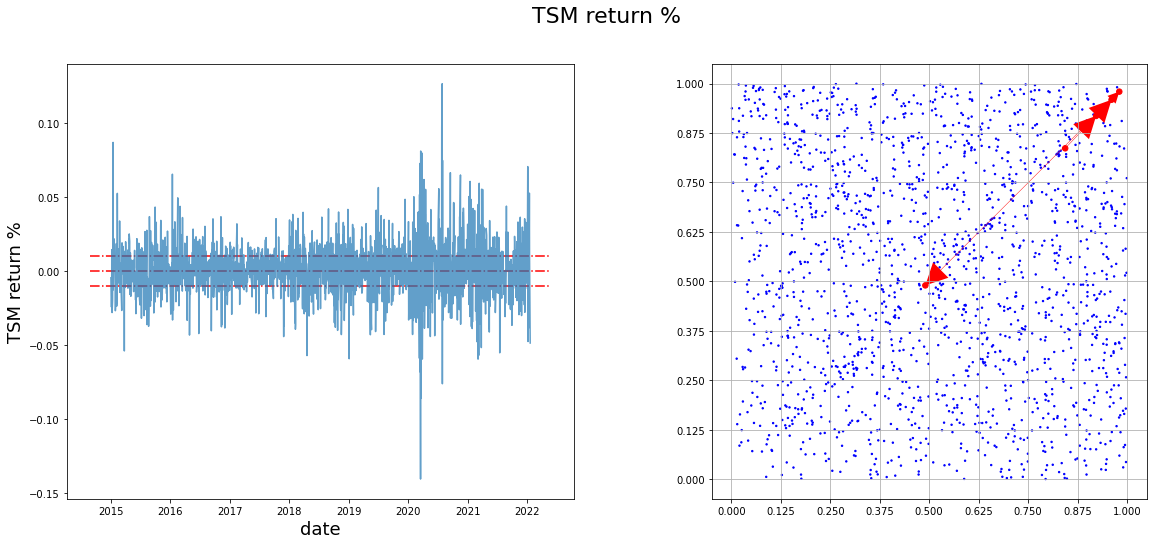

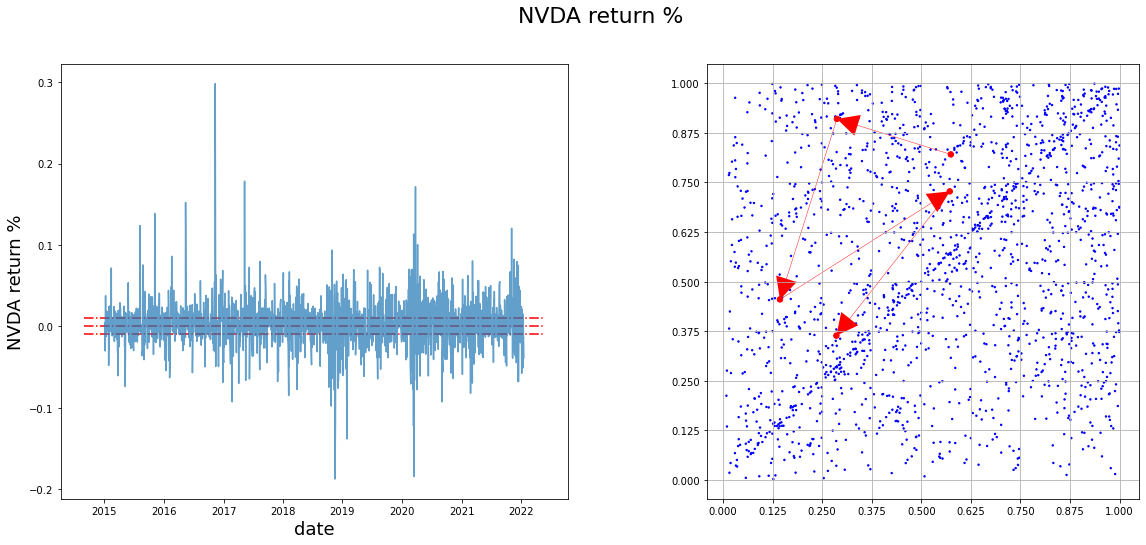

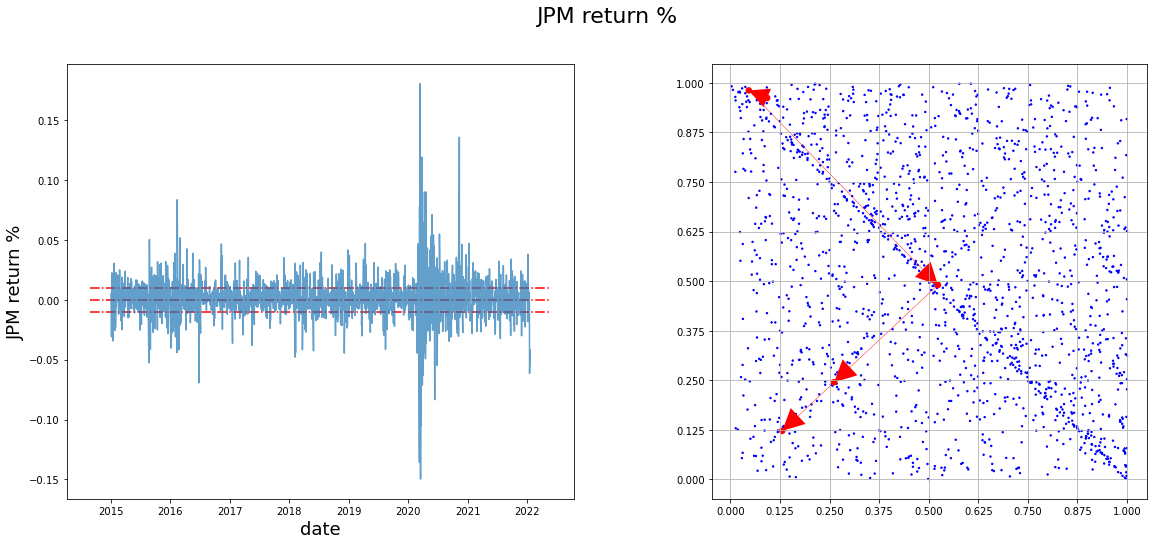

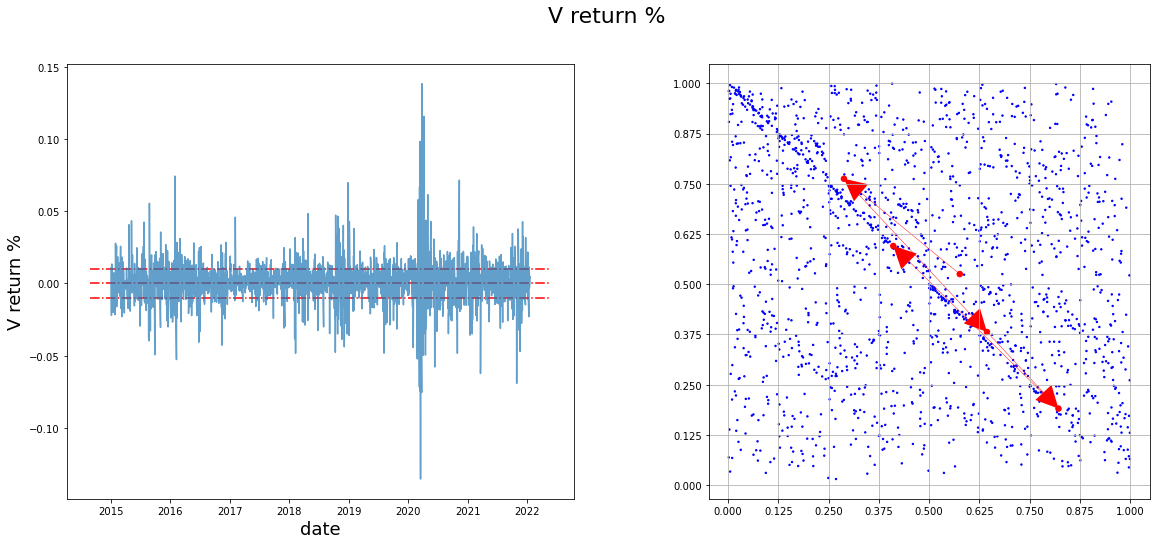

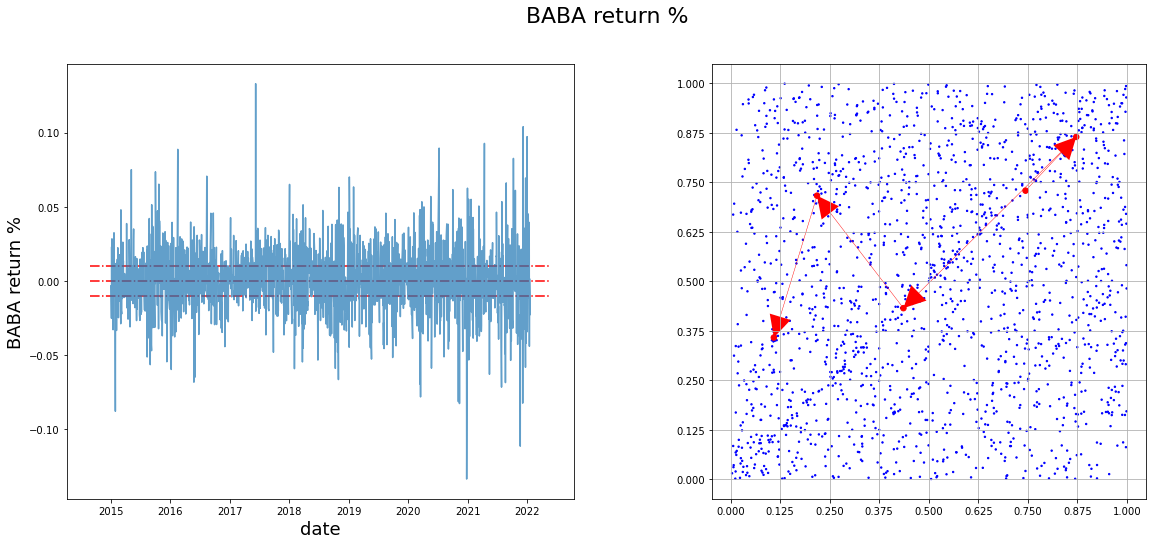

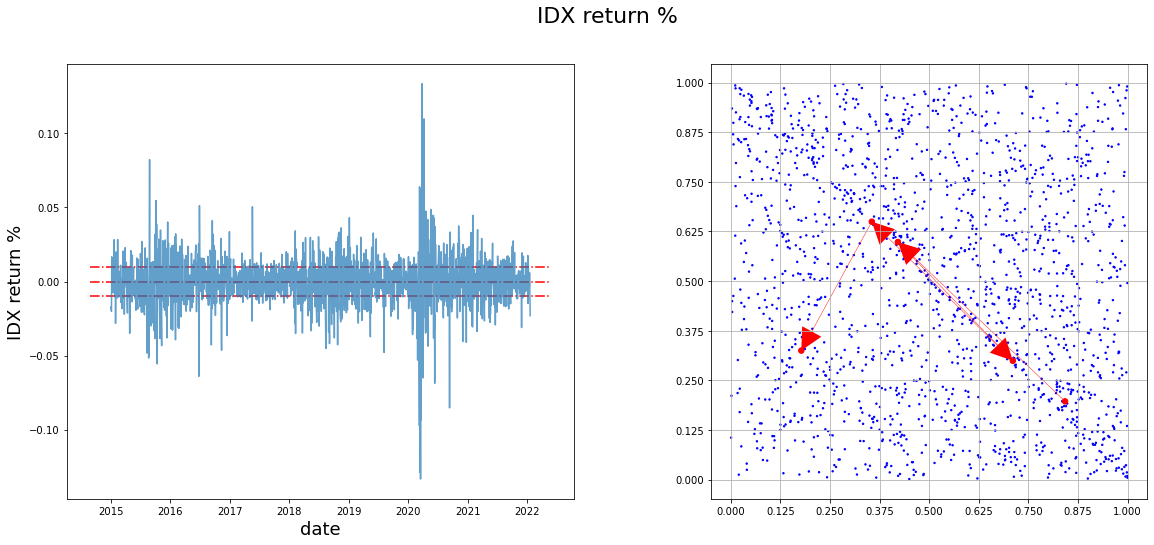

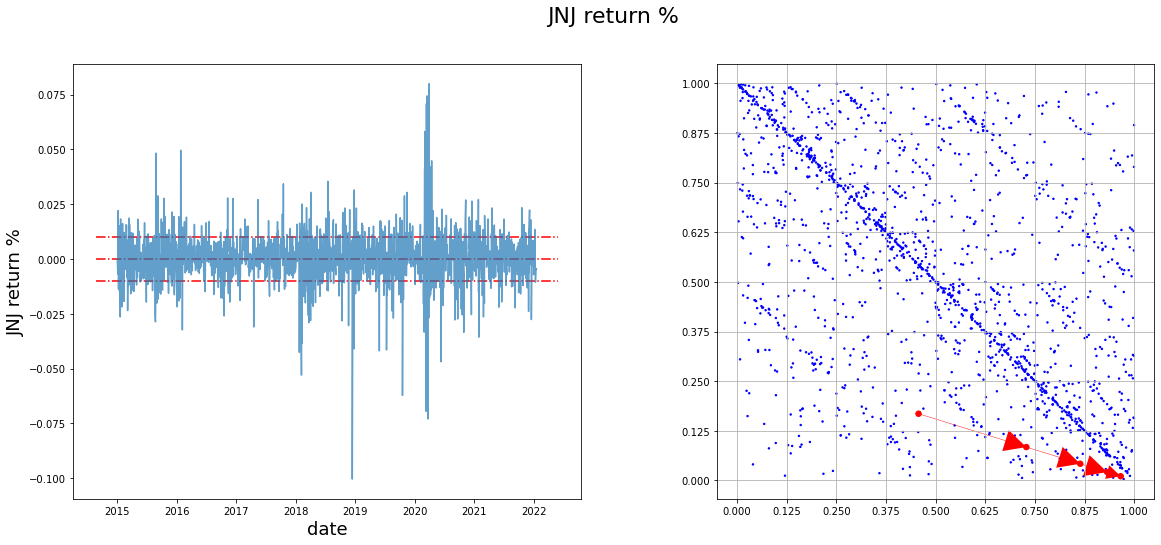

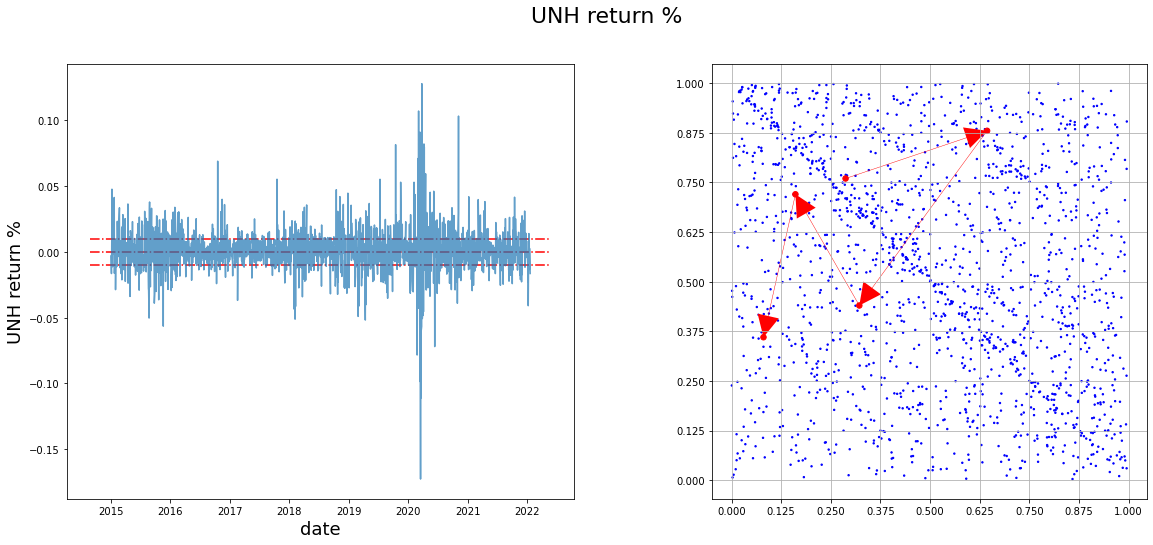

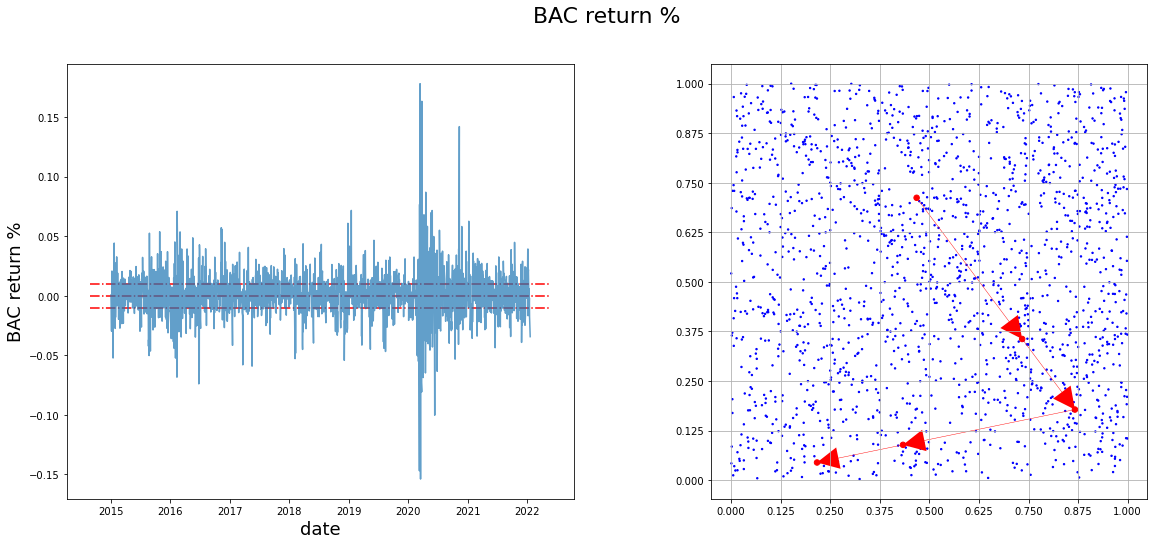

In [24]:
for t in ticker_list:
    series,sequence = data2sequence(get_data(t,start='2015-01-01',end='2022-01-19',n_days=1774),
                                    pct_change=True,equal_width=True,std_norm=False)
    ticker_ifs[t]=sequence
    create_plot(series,sequence,title=f"{t} return %")
    

In [26]:
msft = get_ifsbin(ticker_ifs["MSFT"],bins=bins8)
tsla = get_ifsbin(ticker_ifs["TSLA"],bins=bins8)

In [27]:
ifs_correlation(msft,tsla)

0.6433802816901408

### Indipendenza della correlazione dal lag

In [28]:
jnj_series,jnj_sequence = data2sequence(get_data("JNJ",start='2015-01-01',end='2021-01-01'),
                                    pct_change=True,equal_width=True,std_norm=False)
jnj_series_l,jnj_sequence_l = data2sequence(get_data("JNJ",start='2016-01-01',end='2022-01-01'),
                                    pct_change=True,equal_width=True,std_norm=False)

In [29]:
len(jnj_sequence)

1511

In [30]:
len(jnj_sequence_l)

1511

In [31]:
jnj_sequence

[1, 1, 1, 3, 2, ..., 2, 2, 2, 3, 2]
Length: 1511
Categories (4, int64): [0 < 1 < 2 < 3]

In [32]:
jnj_sequence_l

[0, 2, 1, 0, 0, ..., 2, 2, 2, 2, 1]
Length: 1511
Categories (4, int64): [0 < 1 < 2 < 3]

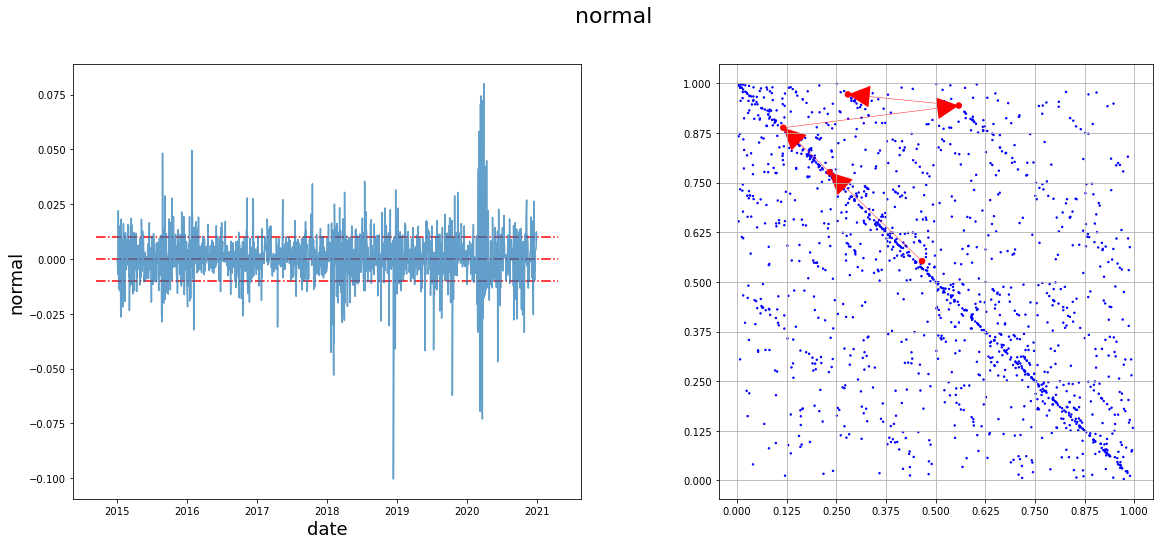

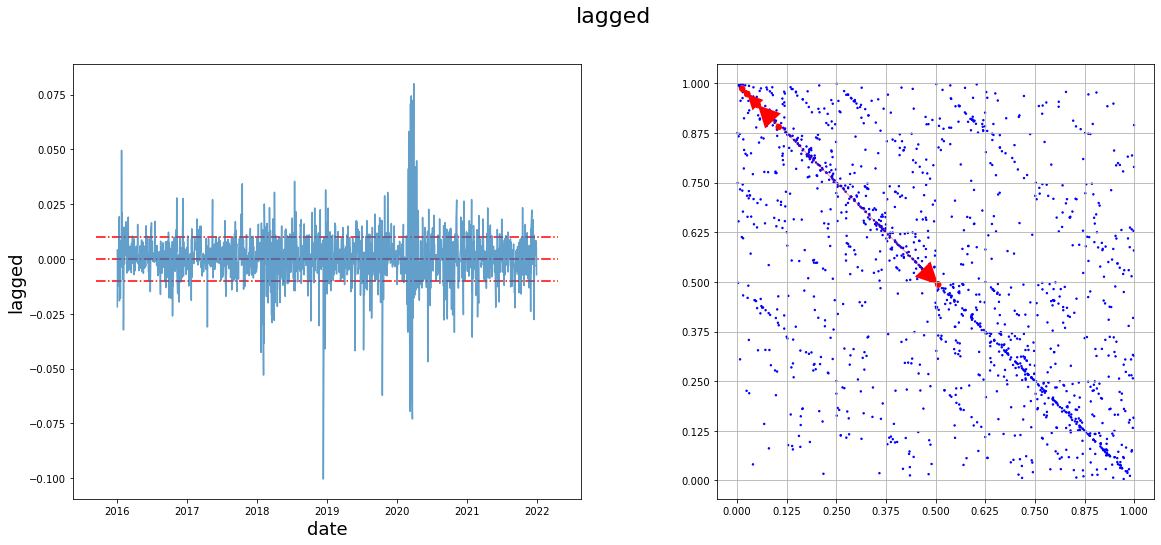

In [33]:
create_plot(jnj_series,jnj_sequence,title="normal")
create_plot(jnj_series_l,jnj_sequence_l,title="lagged")

In [34]:
bins = [0.125*i for i in range(0,9)]
jnj_ifs = get_ifsbin(jnj_sequence,bins=bins)
jnj_ifs_l = get_ifsbin(jnj_sequence_l,bins=bins)
ifs_correlation(jnj_ifs,jnj_ifs_l)
ifs_correlation(jnj_ifs,jnj_ifs_l)

0.9517195767195766

In [35]:
logistic_series_01,logistic_sequence_01 = logistic2sequence(1774,x0=0.1)
logistic_series_02,logistic_sequence_02 = logistic2sequence(1774,x0=0.2)

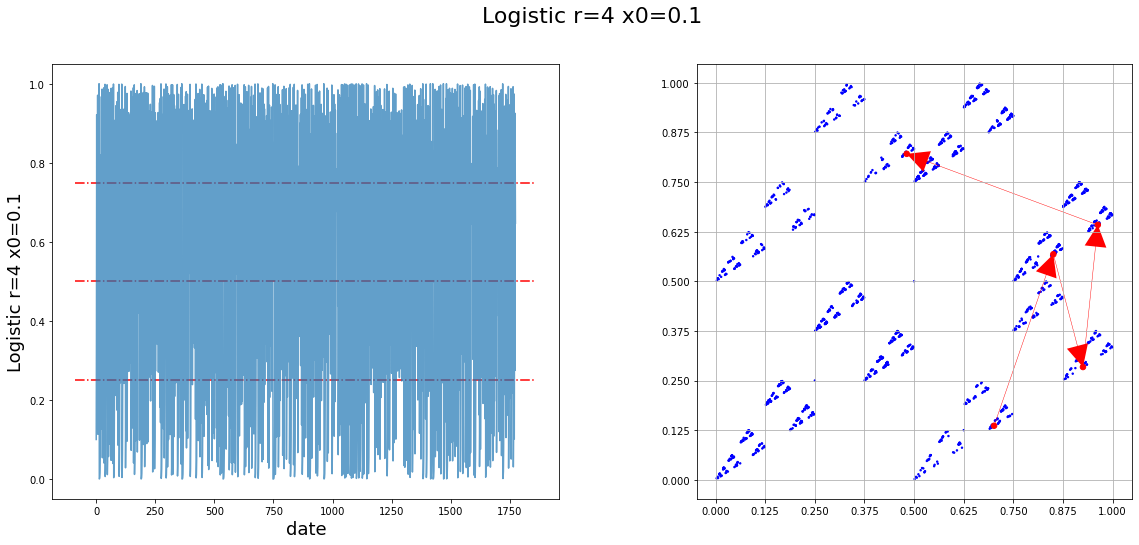

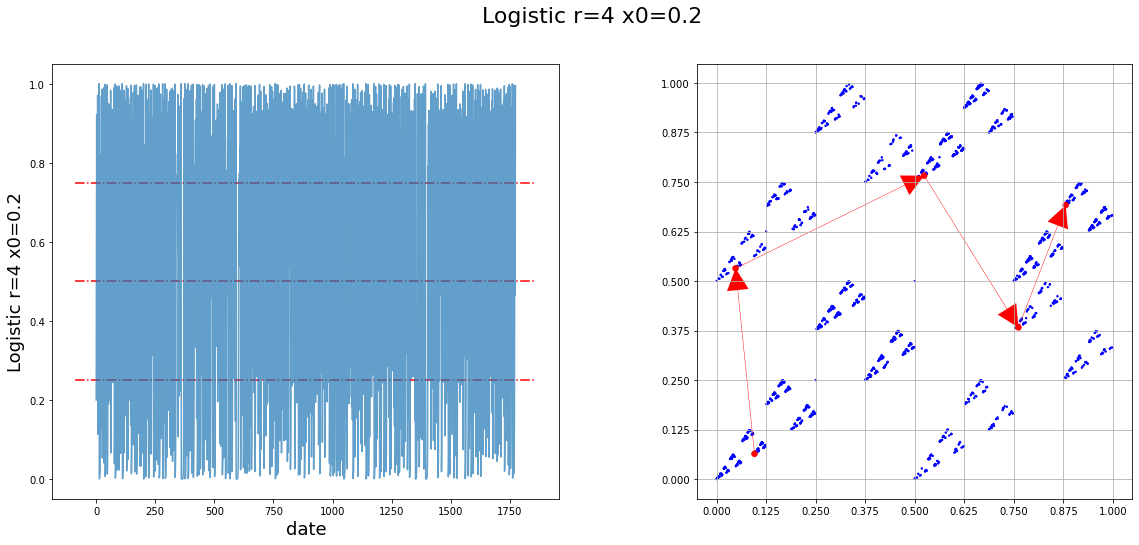

In [50]:
create_plot(logistic_series_01,logistic_sequence_01,hlines=True,title="Logistic r=4 x0=0.1",intervals=[0.,0.25,0.5,0.75,1.])
create_plot(logistic_series_02,logistic_sequence_02,hlines=True,title="Logistic r=4 x0=0.2",intervals=[0.,0.25,0.5,0.75,1.])

In [51]:
logistic_series_01.corr(logistic_series_02)

0.0009899043369382685

In [52]:
log_01_ifs = get_ifsbin(logistic_sequence_01,bins=bins8)
log_02_ifs = get_ifsbin(logistic_sequence_02,bins=bins8)
ifs_correlation(log_01_ifs,log_02_ifs)

0.9307432432432432

In [53]:
log_01_ifs = get_ifsbin(logistic_sequence_01,bins=bins4)
log_02_ifs = get_ifsbin(logistic_sequence_02,bins=bins4)
ifs_correlation(log_01_ifs,log_02_ifs)

0.9605855855855856